# Non-Unitary Operators for the Non-Hermitian Skin Effect

Paper to be replicated: https://arxiv.org/pdf/2311.10143

Addition Resources Consulted:
- https://link.aps.org/pdf/10.1103/PRXQuantum.2.010342
- https://medium.com/mdr-inc/time-evolution-operators-be2968493b86 (note there are some notable errors)
- 

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector

from tqdm.notebook import tqdm

from numpy import sin, cos
import numpy as np
from scipy.linalg import expm, sqrtm

from scipy.optimize import differential_evolution, dual_annealing, minimize

from itertools import product

import random

import json





In [4]:
# service = QiskitRuntimeService()
BACKEND = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=BACKEND, optimization_level=0)
estimator = Estimator(mode=BACKEND)
sampler = Sampler(mode=BACKEND)

## I. Hatano-Nelson Model

Note $\hat{X}^+ = \frac{\hat{X} + i \hat{Y}}{2}$ and $\hat{X}^- = \frac{\hat{X} - i \hat{Y}}{2}$

In [5]:
X_gate = np.array([[0, 1], 
                   [1, 0]])

Y_gate = np.array([[0, -1j],
                   [1j, 0]])

I_gate = np.array([[1, 0], 
                   [0, 1]])

X_plus = 0.5 * (X_gate + 1j * Y_gate)
X_minus = 0.5 * (X_gate - 1j * Y_gate)

In [6]:
# Helper function, generates U_j_nonH
def get_U_j_nonH(J, gamma, index, N, timestep):
    product_1 = np.kron(X_plus, X_minus)
    product_2 = np.kron(X_minus, X_plus)
    exponent = 1j * timestep * ( (J - gamma) * product_1 + (J + gamma) * product_2)
    
    if index == 0:
        U_j_nonH = np.kron(np.eye(2 ** (N-2)), expm(exponent))
    if index == N - 2:
        U_j_nonH = np.kron(expm(exponent), np.eye(2 ** (N-2)))
    else: 
        U_j_nonH = np.kron(np.kron(np.eye(2 ** (N - 2 - index)), expm(exponent)), np.eye(2 ** (index)))
    return U_j_nonH
    


# Helper function, generates R_HN
def get_R_HN(J, gamma, N, timestep):
    res_even = np.eye(2 ** N)
    res_odd = np.eye(2 ** N)
    for i in range(N - 1):
        if i % 2 == 0:
            res_even = np.matmul(res_even, get_U_j_nonH(J, gamma, i, N, timestep))
        else:
            res_odd = np.matmul(res_odd, get_U_j_nonH(J, gamma, i, N, timestep))
    return np.matmul(res_even, res_odd)

# Generates U_HN 
def get_U_HN(J, gamma, N, timestep):
    R_HN = get_R_HN(J, gamma, N, timestep)

    A, sig, Bh = np.linalg.svd(R_HN)
    eigval, _ = np.linalg.eig(np.matmul(R_HN.conj().T, R_HN))
    u_square_inverse = max(eigval)
    u_square = 1/u_square_inverse 
    C = np.matmul(np.matmul(A, sqrtm(np.eye(2 ** N) - u_square * np.diag(np.square(sig)))), Bh)

    u_R_HN = np.sqrt(u_square) * R_HN
    W = np.concatenate((np.concatenate((u_R_HN, C), axis=0), np.concatenate((np.eye(2 ** N), np.eye(2 ** N)), axis=0)), axis=1)
    U_HN, _ = np.linalg.qr(W)
    return U_HN

In [7]:
def projection(N):
    projector = np.array([[1.0, 0.0], [0.0, 0.0]])
    
    return np.kron(projector, np.eye(2 ** (N-1)))

projection(3)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [8]:
total_time = 1.8
nb_timesteps = 10
timestep_duration = total_time/nb_timesteps

# First Attempt Using Gates
Note: This attempt missed out on implementing the projection between each trotter step, hence the non-unitary case where $gamma \neq 0.0$ gives the wrong figure.

Text(0.5, 0, 'T')

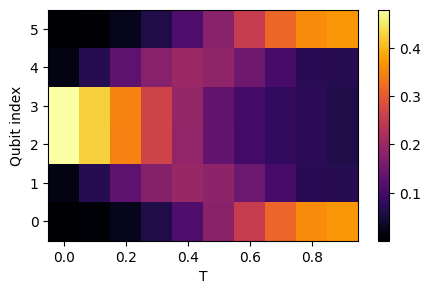

In [10]:
# For gamma = 0.0 case 
# (Original Implementation using individual UnitaryGates, but missed out projection between each trotter step)
N = 6

# Generate the unitary
matrix = get_U_HN(2, 0.0, N, 0.1)
gate = UnitaryGate(matrix)

# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    qc.h(N//2 - 1)
    qc.cx(N//2 - 1, N//2)
    
    gate = UnitaryGate(np.linalg.matrix_power(matrix, n_steps))
    qc.append(gate, [i for i in range(N+1)])
    
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
# for circ in tqdm(circuits):
for circ in circuits:
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '1':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

fig = plt.figure(figsize=(10/2,6/2), facecolor='white')
im = plt.pcolormesh([0.1 * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')



In [12]:
# For gamma = 0.5 case 
# (Original Implementation using individual UnitaryGates, but missed out projection between each trotter step)
N = 6

# Generate the unitary
matrix = get_U_HN(2, 0.5, N, 0.1)
gate = UnitaryGate(matrix)

# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    qc.h(N//2 - 1)
    qc.cx(N//2 - 1, N//2)
    
    gate = UnitaryGate(np.linalg.matrix_power(matrix, n_steps))
    qc.append(gate, [i for i in range(N+1)])
    
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
# for circ in tqdm(circuits):
for circ in circuits:
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '1':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

Text(0.5, 0, 'T')

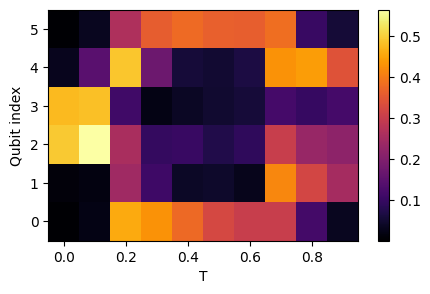

In [13]:
fig = plt.figure(figsize=(10/2,6/2), facecolor='white')
im = plt.pcolormesh([0.1 * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Second Attempt: Mathematical implementation of Fig 3a
Note: Qiskit was not used

(6, 10)


Text(0.5, 0, 'T')

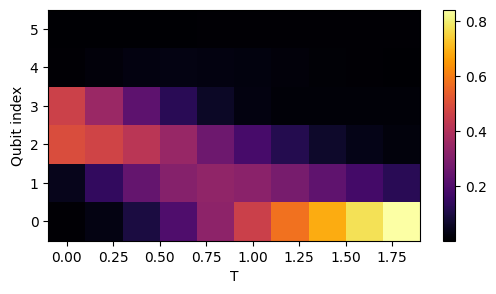

In [14]:
# For gamma = 0.5 case 
# (Full matrices and state vector based, no qiskit)
N = 6
nb_timesteps = 10
timestep_duration = 0.2
gamma = 0.5
J = 1

# Generate the unitary
matrix = get_U_HN(J, gamma , N, timestep_duration)
projection_matrix = projection(N+1)

# create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)

magnetization=[]
for n_steps in range(1, nb_timesteps + 1):

    # for each time step, apply the matrix n_steps times onto the initial vector
    state_vector = np.matmul(np.linalg.matrix_power(matrix @ projection_matrix, n_steps), initial_vector).T[0]
    state_dict = {}
    for i in range(2 ** (N+1)):

        # allocate the relevant probabilities to each state
        state_dict[bin(i)[2:].zfill(N+1)] = np.abs(state_vector[i]) ** 2

   
    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        # key[0] is the ancillary qubit
        if key[0] == '0':
            prob += value
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    magnetization += [[x/prob for x in row]]

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Third Attempt: Adapting the Mathematical Representation to Qiskit
Note: the `Statevector` Class was used, however sampler was not used as far as I am aware.

The first attempt follows the method detailed in the paper. Since a second non-unitary operation (the projection between each trotter step) was necessary, I adopted using the `Statevector` class which came with an `evolve` method which can take non-unitary operators. However, I am not sure why we cannot use this directly with the non-unitary HN operator.


In [15]:
# For gamma = 0.5 case 
# Adapting the math representation to Qiskit
N = 6
J = 1
gamma = 0.5
timestep_duration = 0.2

# Generate the unitary
matrix = get_U_HN(J, gamma, N, timestep_duration)
projection_matrix = projection(N+1)
gate = Operator(matrix)
projector = Operator(projection_matrix)

initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)


magnetization=[]
# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    state = Statevector(initial_vector)
    
    for _ in range(n_steps):
        state = state.evolve(gate)
        state = state.evolve(projector)
    
    # qc.measure_all()
    # circuits.append(qc)
    circuits.append(state)

# Execute measurements for paper's Fig 3a
density=[]
res_list = []
for circ in tqdm(circuits):
    # pubs = [(circ)]
    # job = sampler.run(pubs, shots=160000)
    # results = job.result()
    # res = results[0].data.meas.get_counts()
    probs = circ.probabilities()
    state_dict = {}
    for i in range(2 ** (N+1)):

        # allocate the relevant probabilities to each state
        state_dict[bin(i)[2:].zfill(N+1)] = np.abs(probs[i])

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        # key[0] is the ancillary qubit
        if key[0] == '0':
            prob += value
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    magnetization += [[x/prob for x in row]]

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

Exception ignored in: <function tqdm.__del__ at 0x125cb1b20>
Traceback (most recent call last):
  File "/Users/seeminlim/Desktop/Professional/.venv/lib/python3.13/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/seeminlim/Desktop/Professional/.venv/lib/python3.13/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

  0%|          | 0/10 [00:00<?, ?it/s]

(6, 10)


Text(0.5, 0, 'T')

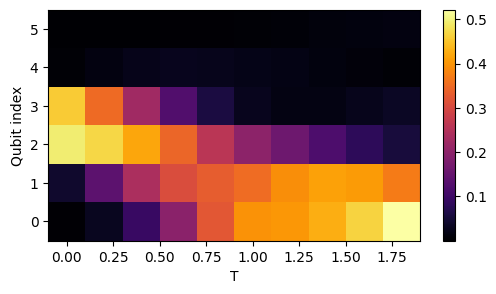

In [177]:
# For gamma = 0.5 case 
# Using R_HN directly
N = 6
J = 1
gamma = 0.5
timestep_duration = 0.2

# Generate the unitary
matrix = get_R_HN(J, gamma, N, timestep_duration)
projection_matrix = projection(N+1)
gate = Operator(matrix)
projector = Operator(projection_matrix)

initial_vector = np.zeros((2**(N), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)


magnetization=[]
# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    state = Statevector(initial_vector)
    
    for _ in range(n_steps):
        state = state.evolve(gate)
        #state = state.evolve(projector)
    
    # qc.measure_all()
    # circuits.append(qc)
    circuits.append(state)

# Execute measurements for paper's Fig 3a
density=[]
res_list = []
for circ in tqdm(circuits):
    # pubs = [(circ)]
    # job = sampler.run(pubs, shots=160000)
    # results = job.result()
    # res = results[0].data.meas.get_counts()
    probs = circ.probabilities()
    state_dict = {}
    for i in range(2 ** (N)):

        # allocate the relevant probabilities to each state
        state_dict[bin(i)[2:].zfill(N)] = np.abs(probs[i])

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        # key[0] is the ancillary qubit
        if True: #key[0] == '0':
            prob += value
            for i in range(0, N):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i - 1] += value

    magnetization += [[x/prob for x in row]]

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Fourth Attempt: Integrating Sampler (and hence adapting for execution on quantum computers)
This is similar to attempt 3, except the `Statevectors` are now made into circuits and `Sampler` can thus be used on them (as far as I am aware). However, my original question in attempt 3 remains, hence there is a second circuit under this attempt (also directly using `R_HN`)

  0%|          | 0/10 [00:00<?, ?it/s]

(6, 10)


Text(0.5, 0, 'T')

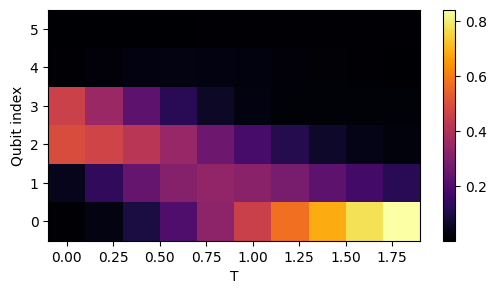

In [184]:
# For gamma = 0.5 case 
# Adapting the math representation to Qiskit
# Using Sampler
N = 6
J = 1
gamma = 0.5
timestep_duration = 0.2

# Generate the unitary
matrix = get_U_HN(J, gamma, N, timestep_duration)
projection_matrix = projection(N+1)
gate = Operator(matrix)
projector = Operator(projection_matrix)

initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)


magnetization=[]
# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    state = Statevector(initial_vector)
    
    for _ in range(n_steps):
        state = state.evolve(gate)
        state = state.evolve(projector)
    
    qc.initialize(state, range(N+1), normalize=True)
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '0':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

  0%|          | 0/10 [00:00<?, ?it/s]

(6, 10)


Text(0.5, 0, 'T')

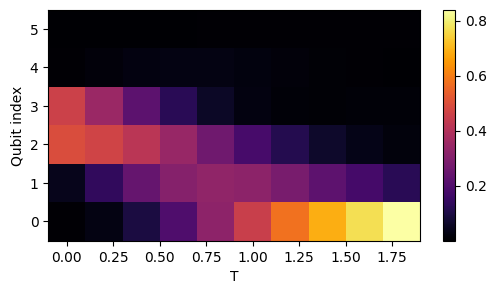

In [186]:
# For gamma = 0.5 case 
# Adapting the math representation to Qiskit
# Using Sampler
N = 6
J = 1
gamma = 0.5
timestep_duration = 0.2

# Generate the unitary
matrix = get_R_HN(J, gamma, N, timestep_duration)
projection_matrix = projection(N+1)
gate = Operator(matrix)
projector = Operator(projection_matrix)

initial_vector = np.zeros((2**(N), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)


magnetization=[]
# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N)
    state = Statevector(initial_vector)
    
    for _ in range(n_steps):
        state = state.evolve(gate)
        # state = state.evolve(projector)
    
    qc.initialize(state, range(N), normalize=True)
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if True: #key[0] == "0":
            counts_left += value

            for i in range(0, N):
                if key[i] == '0':
                    row[i] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Attempt 6: Using VQA -- adapting from attempt 2

In [16]:
np.matmul(np.linalg.matrix_power(projection_matrix @ matrix, 1), initial_vector).T[0]

array([ 0.00000000e+00+0.00000000e+00j,  6.68492214e-34-1.23646945e-33j,
       -6.14729885e-33-6.14631197e-33j, -3.65663430e-17-1.47733922e-18j,
       -2.41749208e-32+2.81676371e-32j,  5.86039017e-18-1.73215912e-17j,
        7.37736743e-17+5.86890666e-20j, -3.83168146e-17+9.77550505e-18j,
        1.18042628e-32-2.04857537e-32j, -1.04031957e-16+7.40530335e-19j,
        9.97291319e-19-1.68220226e-17j, -8.01116363e-18-2.62968650e-17j,
       -1.29506937e-16-5.27060589e-17j, -6.68703656e-18+3.32003294e-17j,
       -3.35724722e-17+3.88982483e-17j,  6.70676277e-17+3.85945414e-18j,
       -3.79445119e-32-2.97715087e-32j,  1.02275651e-18-3.86313951e-17j,
        1.08697190e-16+5.11808955e-17j,  2.26684683e-17-2.99485655e-17j,
        1.25945809e-18-1.63621215e-17j,  1.69765803e-17-2.61242980e-17j,
        3.92886838e-17+5.31118782e-18j, -1.61521316e-17+3.07034212e-17j,
        7.12109414e-17-6.57437565e-18j, -1.51443582e-17-7.47633732e-18j,
       -3.01827912e-17-4.69342595e-17j, -7.15895560

In [17]:
# For gamma = 0.5 case 
# (Full matrices and state vector based, no qiskit)
N = 6
nb_timesteps = 10
timestep_duration = 0.2
gamma = 0.5
J = 1

# Generate the unitary
matrix = get_U_HN(J, gamma , N, timestep_duration)
projection_matrix = projection(N+1)

# create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)

states_all_circuits={}
for n_steps in range(1, nb_timesteps + 1):

    # for each time step, apply the matrix n_steps times onto the initial vector
    state_vector = np.matmul(np.linalg.matrix_power(projection_matrix @ matrix, n_steps), initial_vector).T[0]
    state_dict = {}
    for i in range(2 ** (N+1)):
 
        # allocate the relevant quasi-probabilities to each state
        # state_dict[bin(i)[2:].zfill(N+1)] = np.abs(state_vector[i]) ** 2

        # original version:
        # state_dict[bin(i)[2:].zfill(N+1)] = state_vector[i]

        # to consider little endian of qiskit:
        string = bin(i)[2:].zfill(N+1)
        string = string[1:] + string[0]
        state_dict[string] = state_vector[i]
    
    states_all_circuits[n_steps] = state_dict



'''
    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        prob += value
        for i in range(1, N + 1):

            # if the other qubits have a result of 0, then add the probabilities to that qubit
            if key[i] == '0':
                row[N - i] += value

    states += [[x/prob for x in row]]

states = np.array(states)

print(states.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), states.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

'''

"\n    # create a new row to add to magnetization array\n    row = [0 for _ in range(N)]\n    prob = 0\n    for key, value in state_dict.items():\n\n        prob += value\n        for i in range(1, N + 1):\n\n            # if the other qubits have a result of 0, then add the probabilities to that qubit\n            if key[i] == '0':\n                row[N - i] += value\n\n    states += [[x/prob for x in row]]\n\nstates = np.array(states)\n\nprint(states.T.shape)\nfig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')\nim = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), states.T, cmap='inferno')\nfig.colorbar(im)\nplt.ylabel('Qubit index')\nplt.xlabel('T')\n\n"

In [18]:
print(states_all_circuits[n_steps])

{'0000000': np.complex128(0j), '0000010': np.complex128(-1.2593500593537499e-33-5.324763759369562e-34j), '0000100': np.complex128(-3.9318164475760835e-35-2.722562159108676e-33j), '0000110': np.complex128(-6.430346891187752e-18-7.796849959600846e-19j), '0001000': np.complex128(-1.388976185959808e-32+1.2716789820244084e-34j), '0001010': np.complex128(-7.238540076201779e-19-5.238954438869388e-18j), '0001100': np.complex128(1.1372899201958289e-17-5.4972921170525286e-18j), '0001110': np.complex128(4.5890883315416094e-18+1.1488660715974069e-18j), '0010000': np.complex128(8.608042217199362e-33+1.8826528361686297e-33j), '0010010': np.complex128(-1.7523624283815716e-17-4.932861335285801e-18j), '0010100': np.complex128(1.233158598865033e-17-2.2641656869870472e-17j), '0010110': np.complex128(-7.523643610055412e-20+1.2957633205269557e-17j), '0011000': np.complex128(-3.2381931639548666e-18-2.3392122364055947e-18j), '0011010': np.complex128(3.4036629466173244e-18-2.022837534154405e-18j), '0011100': 

In [19]:
print(initial_vector)

[[0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.707106

In [ ]:
def unitary_gate_matrix(theta, phi, lam):
    return np.array([[np.cos(theta/2), -np.exp(lam * 1j) * np.sin(theta/2)]
                    [np.exp(phi * 1j) * np.sin(theta/2), np.exp(1j * (phi + lam)) * np.cos(theta/2)]])

In [ ]:
cx_matrix = np.array([[1, 0, 0, 0], 
                     [0, 1, 0, 0], 
                     [0, 0, 0, 1],
                     [0, 0, 1, 0]])

cx_matrices = np.kron(np.kron(cx_matrix, cx_matrix), cx_matrix)

cx_matrix_v1 = np.kron(cx_matrices, np.eye(2))
cx_matrix_v2 = np.kron(np.eye(2), cx_matrices)

NameError: name 'np' is not defined

In [ ]:
def variational_circuit_mathematical(params):
    stepper = 0
    layers = 8

    state = initial_vector.copy()

    
    matrix = unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2])
    stepper += 1
    for _ in range(N):
        matrix = np.kron(unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2]), matrix)
        stepper += 1
    state = np.matmul(matrix, state)

    


    for _ in range(layers):
        state = np.matmul(cx_matrix_v1, state)
        matrix = np.eye(2)
        for _ in range(N):
            matrix = np.kron(unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2]), matrix)
            stepper += 1
        state = np.matmul(matrix, state)
        state = np.matmul(cx_matrix_v1, state)

        state = np.matmul(cx_matrix_v2, state)
        matrix = unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2])
        stepper += 1
        for _ in range(N - 1):
            matrix = np.kron(unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2]), matrix)
            stepper += 1
        matrix = np.kron(np.eye, matrix)
        state = np.matmul(matrix, state)
        state = np.matmul(cx_matrix_v2, state)
        



    


In [ ]:
def variational_circuit(params):
    qc = QuantumCircuit(N+1)
    stepper = 0
    layers = 8

    qc.x(range(1, 3))
    qc.x(range(5, N+1))
    qc.h(3)
    qc.cx(3, 4)
    qc.x(4)

    # initial
    for qubit in range(N+1):
        qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit)
        stepper += 1
    
    for layer in range(layers):
        # CX gates
        qc.cx(0, 1)
        qc.cx(2, 3)
        qc.cx(4, 5)

        # first set of U3 gates
        while qubit in range(N):
            qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit)
            stepper += 1
        
        # CX gates
        qc.cx(0, 1)
        qc.cx(2, 3)
        qc.cx(4, 5)

        # CX gates
        qc.cx(1, 2)
        qc.cx(3, 4)
        qc.cx(5, 6)

        # first set of U3 gates
        while qubit in range(N):
            qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit+1)
            stepper += 1
        
        # CX gates
        qc.cx(1, 2)
        qc.cx(3, 4)
        qc.cx(5, 6)

    qc.measure_all()

    return qc




In [21]:
def calculate_results(params):

    # initialization of the sampler
    sampler = Sampler(mode=BACKEND)
    
    # Sampler runs a job on the Bell circuit
    job = sampler.run([(variational_circuit(params))])
    job_result = job.result()
    return job_result[0].data.meas.get_counts(), job_result[0].metadata['shots']

In [22]:
def cost_function(params, n_steps):
    results, shots = calculate_results(params)
    sum = 0
    for key in results:
        sum += np.conj(np.sqrt(results[key]/shots)) * states_all_circuits[n_steps][key]

    return 1 - np.abs(sum)

In [ ]:
# scipy
# matrix product state

In [23]:
cost_function(np.ones((((N+1) + (N * 2 * 8)) * 3)), 8)

np.float64(0.9743571287872698)

In [24]:
#params0 = np.ones((((N+1) + (N * 2 * 8)) * 3))
#params0 = np.([np.pi for _ in range(((N+1) + (N * 2 * 8)) * 3)])
randoms = np.random.rand(((N+1) + (N * 2 * 8)) * 3)
# params0 = np.array([i * np.pi if i % 3 == 0 else i * 2 * np.pi for i in randoms])
params0 = np.array([0.0 for i in randoms])
bounds = tuple([(0.0, np.pi) if i % 3 == 0 else (0.0, 2 * np.pi) for i in range(((N+1) + (N * 2 * 8)) * 3)])
print(len(params0))



309


In [25]:
calculate_results(params0)

({'1110110': 523, '1101110': 501}, 1024)

In [26]:
cost_function(params0, 1)

np.float64(0.30839398700636655)

In [27]:
states_all_circuits[1]

{'0000000': np.complex128(0j),
 '0000010': np.complex128(6.6849221376257205e-34-1.2364694548330462e-33j),
 '0000100': np.complex128(-6.1472988499879264e-33-6.1463119726443224e-33j),
 '0000110': np.complex128(-3.656634295632328e-17-1.4773392172026571e-18j),
 '0001000': np.complex128(-2.4174920754563553e-32+2.816763709638737e-32j),
 '0001010': np.complex128(5.860390171003141e-18-1.732159122539683e-17j),
 '0001100': np.complex128(7.377367426354249e-17+5.868906661202172e-20j),
 '0001110': np.complex128(-3.831681464058006e-17+9.77550504970931e-18j),
 '0010000': np.complex128(1.1804262793123828e-32-2.0485753733866243e-32j),
 '0010010': np.complex128(-1.0403195734203423e-16+7.405303349052455e-19j),
 '0010100': np.complex128(9.972913194497789e-19-1.6822022628338232e-17j),
 '0010110': np.complex128(-8.01116363418184e-18-2.6296864965152372e-17j),
 '0011000': np.complex128(-1.2950693676146772e-16-5.2706058936558096e-17j),
 '0011010': np.complex128(-6.687036564712445e-18+3.320032944839262e-17j),
 

In [ ]:
res = minimize(cost_function, params0, args=3, method='COBYLA', bounds=bounds)
# L-BFGS-B

KeyboardInterrupt: 

Exception ignored in: <function tqdm.__del__ at 0x125cb1b20>
Traceback (most recent call last):
  File "/Users/seeminlim/Desktop/Professional/.venv/lib/python3.13/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/seeminlim/Desktop/Professional/.venv/lib/python3.13/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x125cb1b20>
Traceback (most recent call last):
  File "/Users/seeminlim/Desktop/Professional/.venv/lib/python3.13/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/seeminlim/Desktop/Professional/.venv/lib/python3.13/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [20]:
res = minimize(cost_function, params0, args=1, method='COBYLA', bounds=bounds)

In [24]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.30769383076817136
       x: [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
    nfev: 1000
   maxcv: 0.0

In [22]:
params_dict = {}
starting_params = params0
for n_steps in range(1, nb_timesteps + 1):
    print("Step number: ", n_steps)
    res = minimize(cost_function, params0, args=n_steps, method='COBYLA', bounds=bounds)

    params_dict[n_steps] = res.x
    starting_params = res.x

Step number:  1
Step number:  2
Step number:  3
Step number:  4
Step number:  5
Step number:  6
Step number:  7
Step number:  8
Step number:  9
Step number:  10


In [22]:
for i in range(1, nb_timesteps+1):
    print(cost_function(params_dict[i], i))
    print(cost_function(np.ones(((N+1) + (N * 2 * 8)) * 3), i))
    print(cost_function(np.zeros(((N+1) + (N * 2 * 8)) * 3), i))

NameError: name 'params_dict' is not defined

In [47]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.9920388985110892
       x: [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
    nfev: 1000
   maxcv: 0.0

In [49]:
params_dict

{1: array([ 2.76539317e-17,  9.82240282e-01,  1.00994303e+00, -2.01336343e-16,
         9.39137931e-01, -1.84666735e-15, -1.04408669e-16,  3.77950655e-02,
        -1.02293662e-14,  8.97068878e-16,  1.00789853e-02, -7.86514137e-15,
         3.67541826e-15,  4.46984356e-03,  1.25019350e-02,  5.11477796e-15,
        -2.05058545e-15,  2.77574435e-02, -3.73431754e-15,  1.32422558e-01,
         1.03907667e-01,  1.63675600e-01,  2.25034409e-01,  1.59042235e-01,
         1.83311502e-01,  1.85475067e-01,  1.12750511e+00,  4.94819642e-02,
         2.99066327e-15,  4.04190570e-15,  1.20346441e-17, -3.18321758e-15,
         4.90406327e-15, -1.92467570e-15, -2.30718222e-15, -6.74980905e-15,
         1.22043650e-02,  7.73823795e-03,  1.85055991e-02,  6.39225471e-02,
         1.55563961e-03,  2.86168896e-02,  1.05442824e-01, -5.28006458e-15,
         1.03822330e-01, -1.08420217e-15,  1.18640549e-01,  2.37657116e-15,
         1.35852880e-02, -4.51461785e-16, -3.93175076e-15,  1.53696500e-15,
         

In [55]:
res = calculate_results(params_dict[5])
res

({'1110110': 514, '1101110': 510}, 1024)

(6, 10)


Text(0.5, 0, 'T')

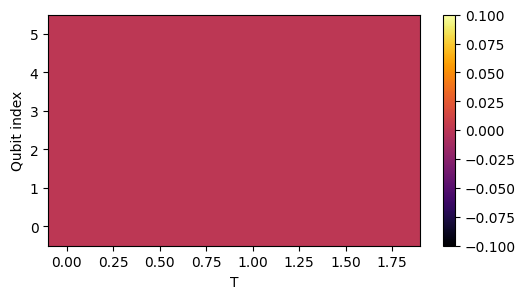

In [23]:
res_all_circuits = []
for n_steps in range(1, nb_timesteps + 1):
    res, counts = calculate_results(params_dict[n_steps])

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in res.items():

        prob += value
        if key[0] == "0":
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    res_all_circuits += [[x/prob for x in row]]

res_all_circuits = np.array(res_all_circuits)

print(res_all_circuits.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), res_all_circuits.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Comparison (Fig S2)

(6, 10)


Text(0.5, 0, 'T')

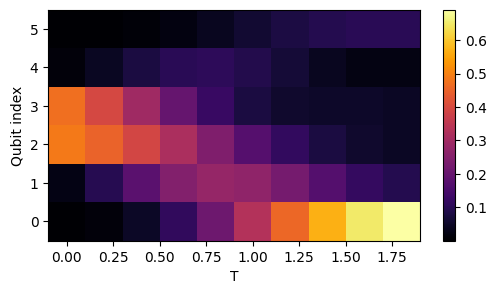

In [39]:
# For gamma = 0.2 case 
# (Full matrices and state vector based, no qiskit)
N = 6
nb_timesteps = 10
timestep_duration = 0.2
gamma = 0.2
J = 1

# Generate the unitary
matrix = get_U_HN(J, gamma , N, timestep_duration)
projection_matrix = projection(N+1)

# create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)

magnetization=[]
for n_steps in range(1, nb_timesteps + 1):

    # for each time step, apply the matrix n_steps times onto the initial vector
    state_vector = np.matmul(np.linalg.matrix_power(matrix @ projection_matrix, n_steps), initial_vector).T[0]
    state_dict = {}
    for i in range(2 ** (N+1)):

        # allocate the relevant probabilities to each state
        state_dict[bin(i)[2:].zfill(N+1)] = np.abs(state_vector[i]) ** 2

   
    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        # key[0] is the ancillary qubit
        if key[0] == '0':
            prob += value
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    magnetization += [[x/prob for x in row]]

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

  0%|          | 0/10 [00:00<?, ?it/s]

(6, 10)


Text(0.5, 0, 'T')

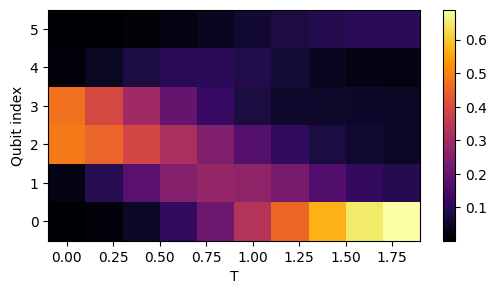

In [38]:
# For gamma = 0.2 case 
# Adapting the math representation to Qiskit
# Using Sampler
N = 6
J = 1
gamma = 0.2
timestep_duration = 0.2

# Generate the unitary
matrix = get_U_HN(J, gamma, N, timestep_duration)
projection_matrix = projection(N+1)
gate = Operator(matrix)
projector = Operator(projection_matrix)

initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)


magnetization=[]
# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    state = Statevector(initial_vector)
    
    for _ in range(n_steps):
        state = state.evolve(gate)
        state = state.evolve(projector)
    
    qc.initialize(state, range(N+1), normalize=True)
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '0':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# nH-SSH Model

In [9]:
def get_N_total(N):
    return int(N + N/2)

In [10]:
def unitary(J, timestep):
    product_1 = np.kron(np.kron(X_gate, I_gate), X_gate)
    product_2 = np.kron(np.kron(Y_gate, I_gate), Y_gate)
    exponent = 1j * timestep * ( (J/2) * (product_1 + product_2))
    return expm(exponent)


def get_unitary(J, timestep, N):
    gate = unitary(J, timestep)
    matrix = np.kron(I_gate, I_gate)
    for _ in range(2, get_N_total(N) - 1, 3):
        matrix = np.kron(matrix, gate)
    matrix = np.kron(matrix, I_gate)
    return matrix


def get_all_U_R(J, gamma, N, timestep):
    gate = get_U_HN(J, gamma, 2, timestep)
    matrix = gate
    for _ in range(1, int(N/2)):
        matrix = np.kron(matrix, gate)
    return matrix

def get_all_projection(N):
    projection_matrix = projection(3)
    matrix = projection_matrix
    for _ in range(1, int(N/2)):
        matrix = np.kron(matrix, projection_matrix)
    return matrix


In [11]:
def check_ancillary(N, key):
    total_N = get_N_total(N)
    for i in range(total_N):
        if i % 3 == 0:
            if key[i] != "0":
                return False
    return True


In [16]:
def get_density(J, gamma, N, nb_timesteps, timestep_duration):
    total_N = get_N_total(N)

    # Generate the unitary
    matrix = get_all_U_R(J, gamma , N, timestep_duration)
    projection_matrix = get_all_projection(N)
    unitary_term = get_unitary(J, timestep_duration, N)

    # create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
    initial_vector = np.zeros((2**(total_N), 1), dtype=complex)
    binary_1 = "" #011" + "010" + "011
    binary_2 = ""
    for index in range(N):
        if index % 2 == 0:
            binary_1 += "0"
            binary_2 += "0"
        
        if index == N/2 - 1:
            binary_1 += "0"
            binary_2 += "1"
        elif index == N/2:
            binary_1 += "1"
            binary_2 += "0"
        else:
            binary_1 += "1"
            binary_2 += "1"
            
    initial_vector[int(binary_1, 2)] = 1/np.sqrt(2)
    initial_vector[int(binary_2, 2)] = 1/np.sqrt(2)

    magnetization=[]
    for n_steps in range(1, nb_timesteps + 1):

        # for each time step, apply the matrix n_steps times onto the initial vector
        state_vector = np.matmul(np.linalg.matrix_power(np.matmul(unitary_term, np.matmul(projection_matrix, matrix)), n_steps), initial_vector).T[0]
        state_dict = {}
        for i in range(2 ** (total_N)):

            # allocate the relevant probabilities to each state
            state_dict[bin(i)[2:].zfill(total_N)] = np.abs(state_vector[i]) ** 2

    
        # create a new row to add to magnetization array
        row = [0 for _ in range(N)]
        prob = 0
        for key, value in state_dict.items():

            # key[0] is the ancillary qubit
            if check_ancillary(N, key):
                prob += value
                for i in range(total_N):

                    # if the other qubits have a result of 0, then add the probabilities to that qubit
                    if i % 3 != 0:
                        if key[i] == '0':
                            real_index = i // 3 * 2 + i % 3
                            row[N - real_index] += value

        magnetization += [[x/prob for x in row]]
    return np.array(magnetization)

In [13]:

nb_timesteps = 10
timestep_duration = 0.1
gamma = 0.5
J = 2



In [17]:
density_6 = get_density(J, gamma, 6, nb_timesteps, timestep_duration)


In [18]:
density_8 = get_density(J, gamma, 8, nb_timesteps, timestep_duration)


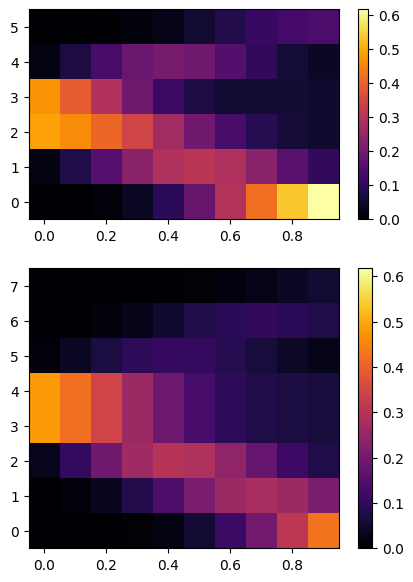

In [34]:
fig, axes = plt.subplots(2, height_ratios=[6, 8], figsize=(10/2, (6 + 8)/2))
plt.inferno()
im_0 = axes[0].pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,6,1), density_6.T, vmin=0, vmax=np.max(density_6))
im_1 = axes[1].pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,8,1), density_8.T, vmin=0, vmax=np.max(density_6))
fig.colorbar(im_0)
fig.colorbar(im_1)

Text(0.5, 0, 'T')

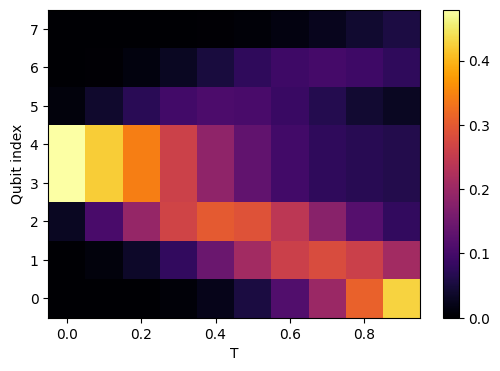

In [41]:
density_8 = magnetization
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), density_8.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')